# Bias Variance Tradeoff for Classification

This notebook provides an approach to finding the bias-variance tradeoff for classification problems.

Author: https://github.com/deburky

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Fetch blended credit data
url = (
    "https://drive.google.com/file/d/1Is8UZnPRExI-SLJMle8GRbFGpha5IvYZ/view?usp=sharing"
)
url = "https://drive.google.com/uc?id=" + url.split("/")[-2]
dataset = pd.read_csv(url, index_col=False)

features = [
    "revolving_utilization_of_unsecured_lines",
    "account_never_delinq_percent",
    "net_fraction_revolving_burden",
    "num_total_cc_accounts",
    "average_months_in_file",
    "balance",
]

target = "is_bad"

# We assign a label of 2 to the records that almost never had delinquency and are bad
label = "label"
condition = (dataset["account_never_delinq_percent"] > 80) & (dataset[target] == 1)
dataset[label] = np.where(condition, 2, dataset[target])

X, y, y_multi = dataset[features], dataset[target], dataset[label]

ix_train, ix_test = train_test_split(
    X.index, stratify=y, test_size=0.3, random_state=62
)

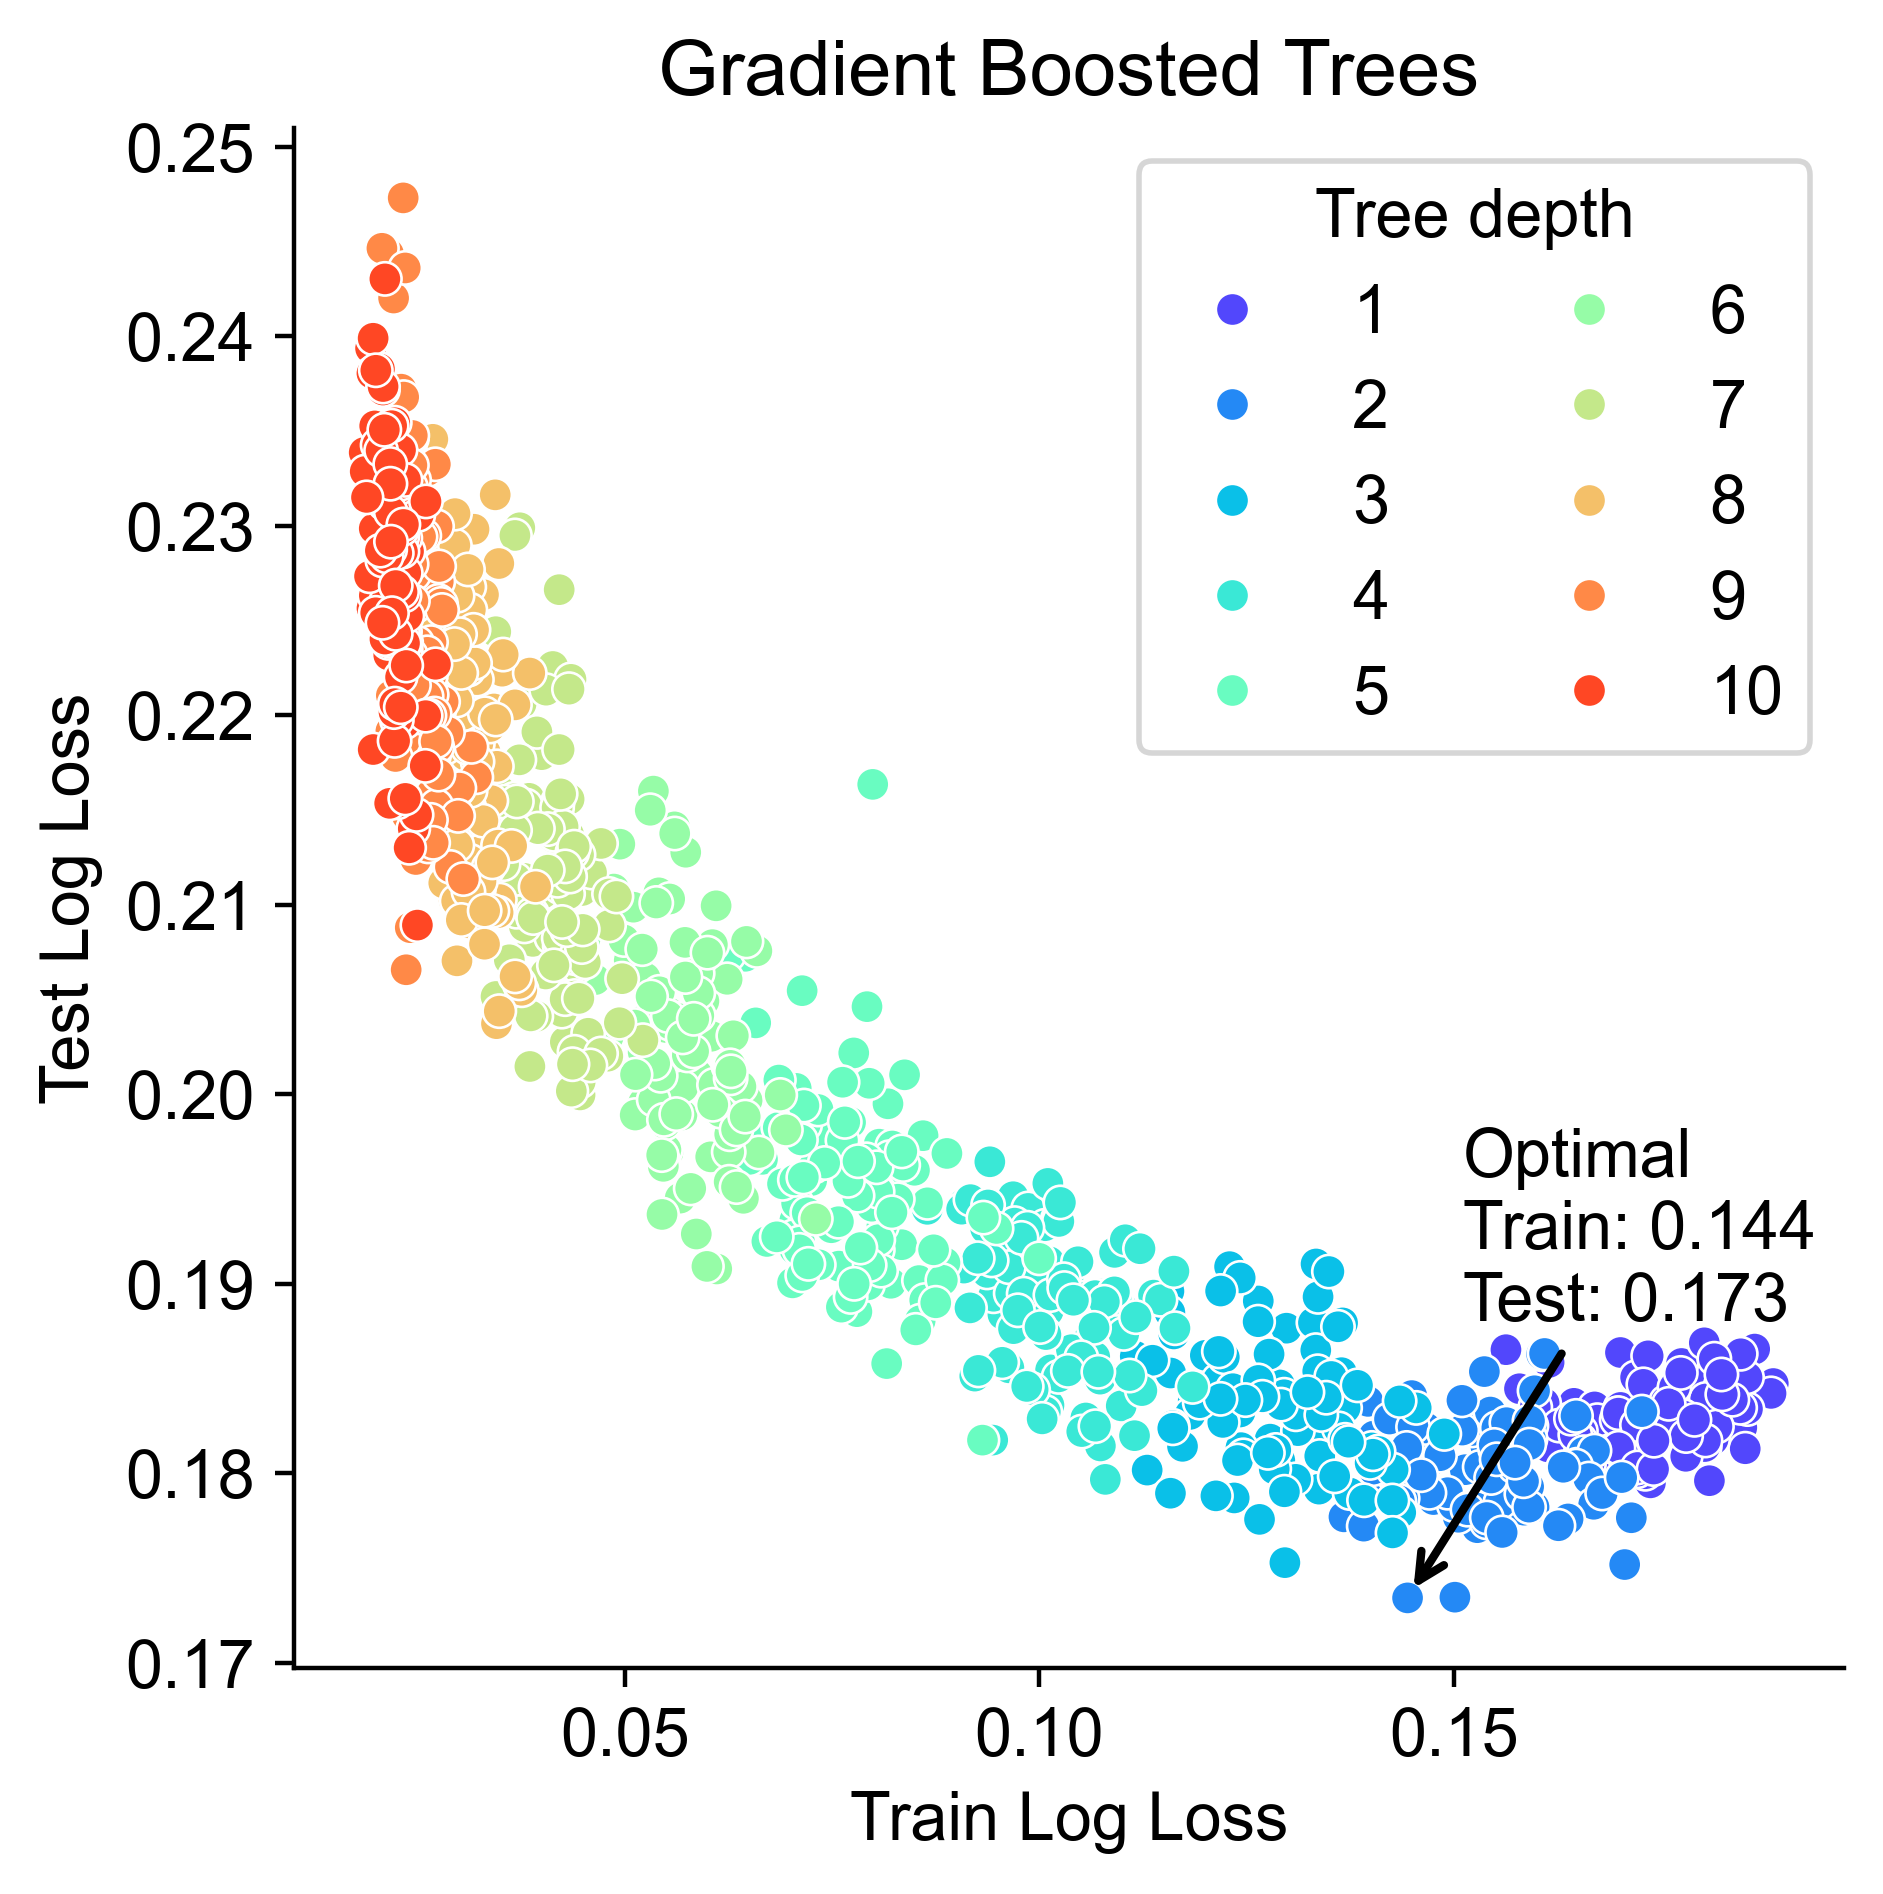

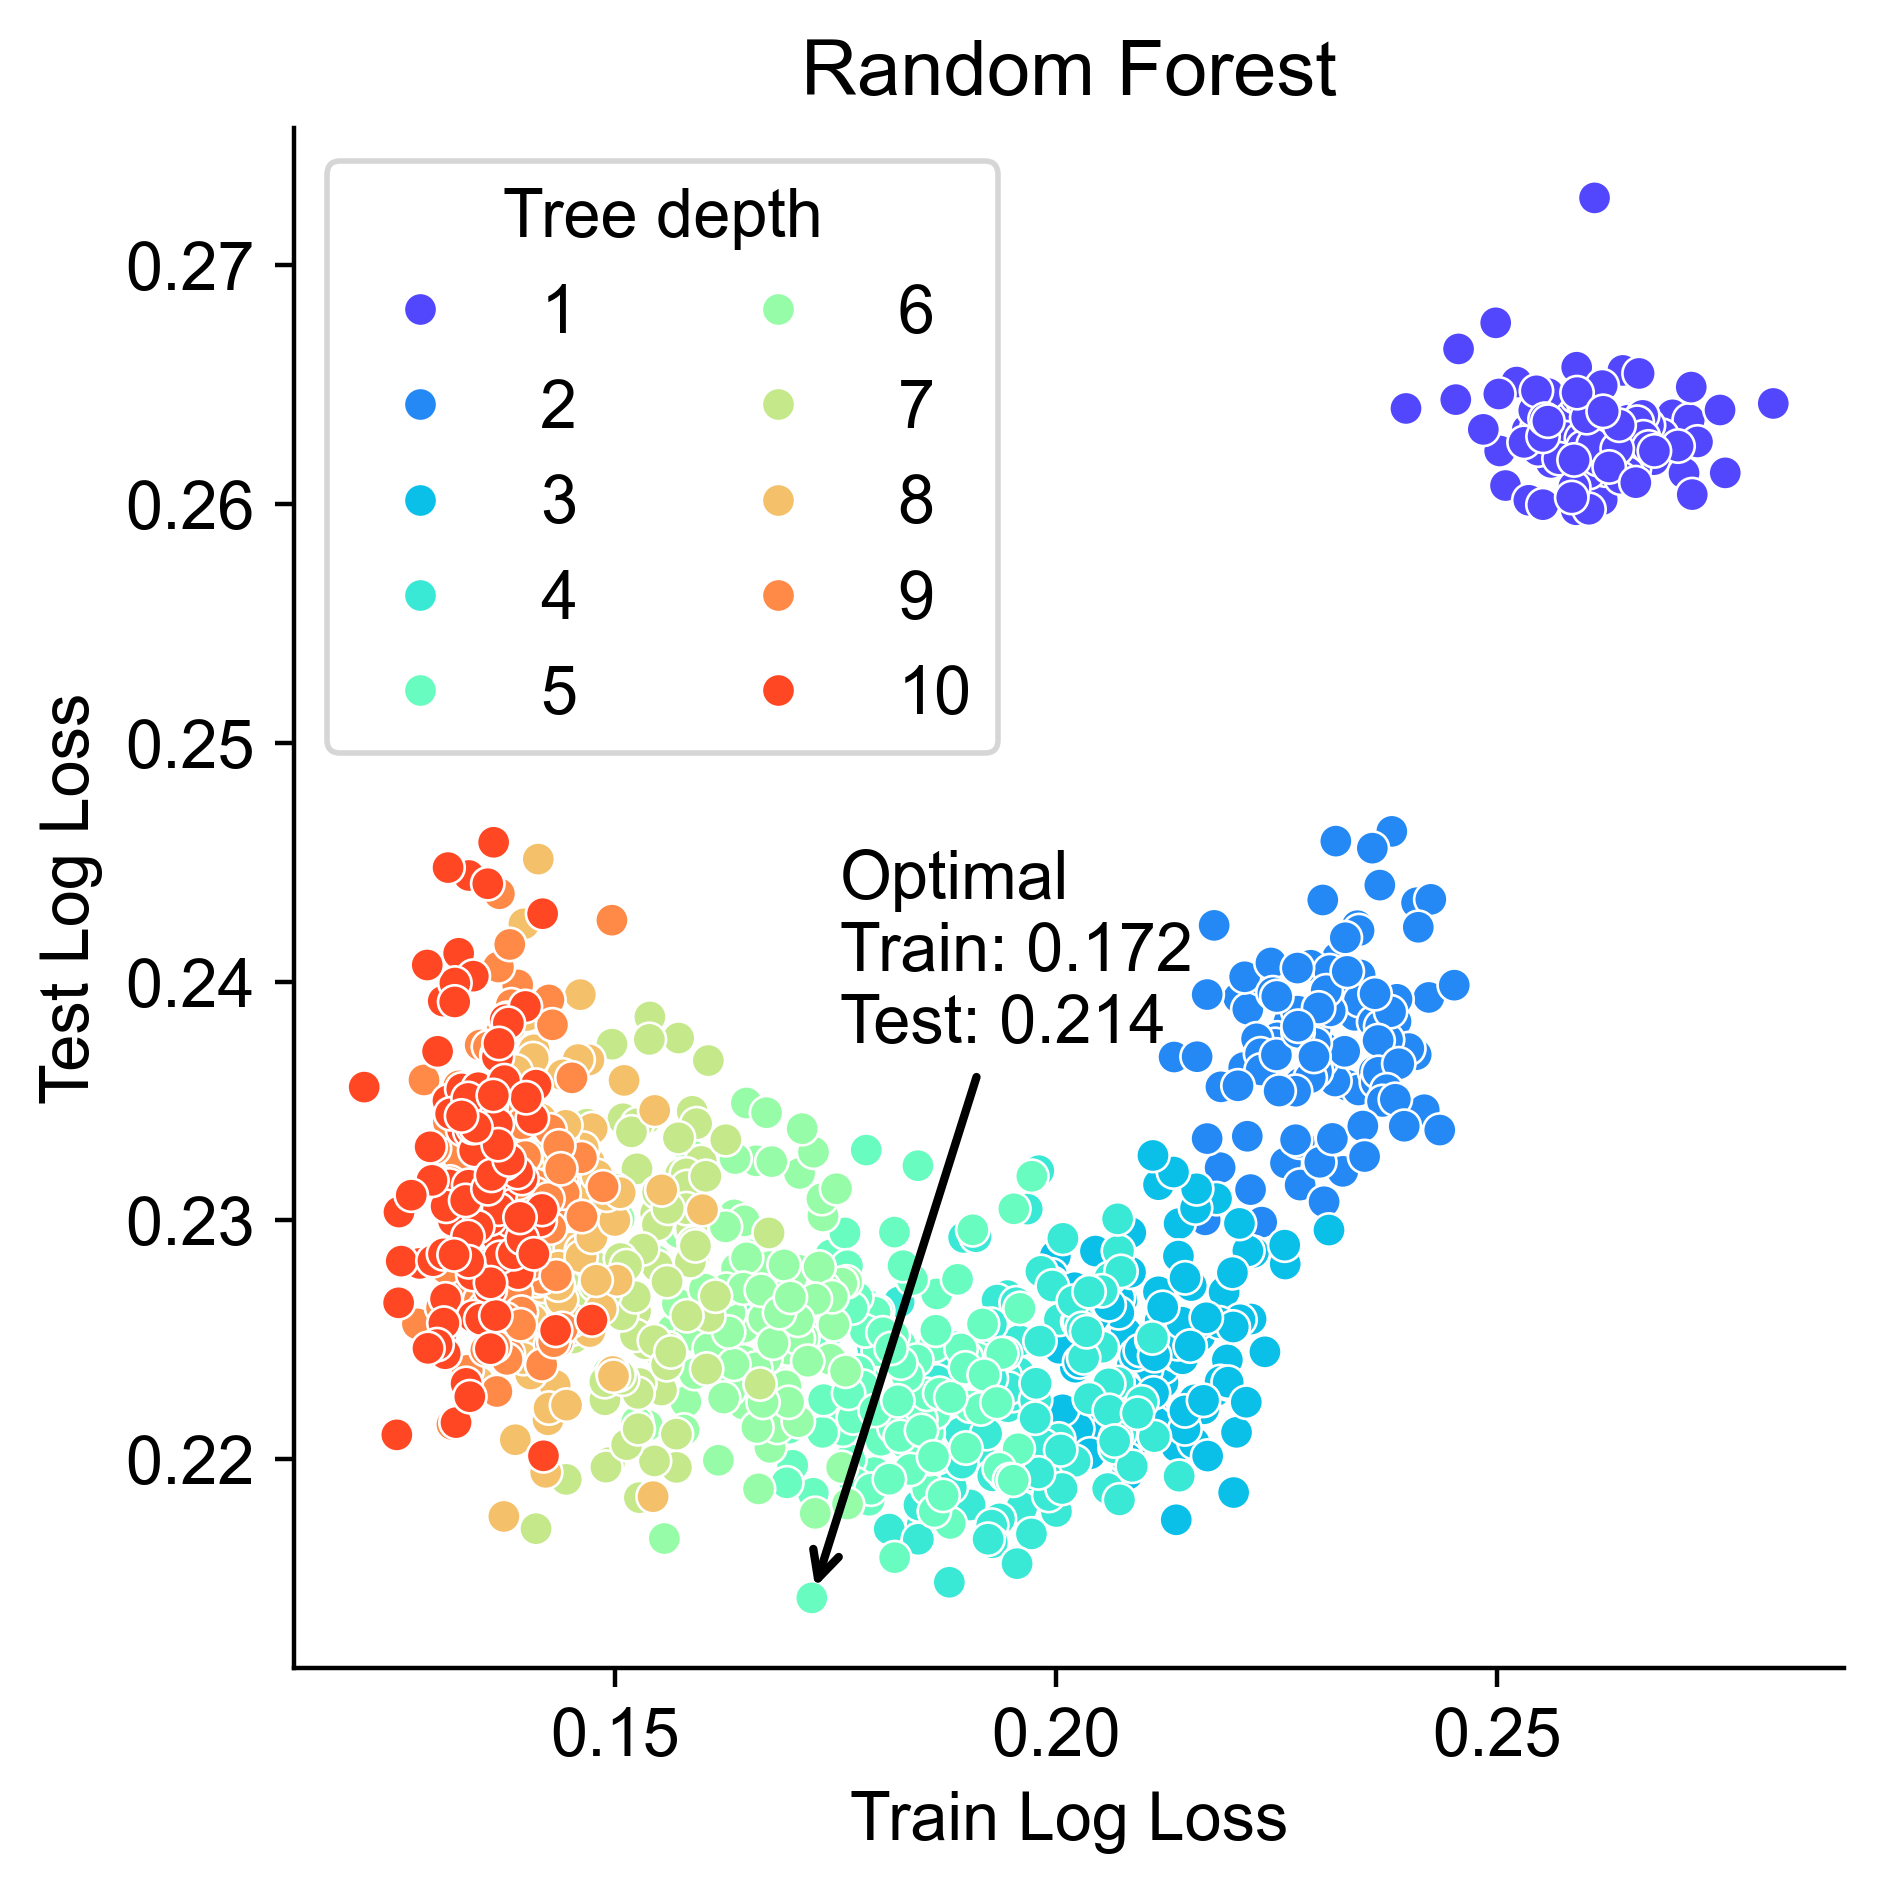

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
import xgboost as xgb
%config InlineBackend.figure_format = 'retina'

# set font to Arial
plt.rcParams["font.family"] = "Arial"

# set font to 14
plt.rcParams.update({"font.size": 12})

# Number of bootstrap samples for each max_depth
num_bootstraps = 100
range_of_max_depth = np.arange(1, 11)
sample_size = int(len(X.loc[ix_train]) * 0.5)

# Define models
models = {
    "Gradient Boosted Trees": xgb.XGBClassifier(n_estimators=30, random_state=42),
    "Random Forest": xgb.XGBRFClassifier(n_estimators=30, random_state=42),
}


def train_model_and_collect_data(
    model, range_of_max_depth, num_bootstraps, sample_size, X, y, ix_train, ix_test
):
    """
    Trains the model using bootstrap sampling and collects train and test loss for each max_depth.
    """
    data_rows = []

    for max_depth in range_of_max_depth:
        model.set_params(max_depth=max_depth)

        for _ in range(num_bootstraps):
            # Generate bootstrap sample with replacement
            random_idx = np.random.choice(ix_train, size=sample_size, replace=True)
            X_boot, y_boot = X.loc[random_idx], y.loc[random_idx]

            # Fit model on the bootstrap sample
            model.fit(X_boot, y_boot)

            # Calculate log loss for train and test sets
            score_train = log_loss(y_boot, model.predict_proba(X_boot)[:, 1])
            score_test = log_loss(
                y.loc[ix_test], model.predict_proba(X.loc[ix_test])[:, 1]
            )

            # Append a row for each bootstrap result
            data_rows.append(
                {
                    "hyperparameter": max_depth,
                    "train_loss": score_train,
                    "test_loss": score_test,
                }
            )

    # Create DataFrame from collected data
    return pd.DataFrame(data_rows)


def plot_scatter(
    data,
    x,
    y,
    hue=None,
    colormap="viridis",
    title="Classification",
    annotate_xytext=(10, 50),
):
    """
    Generate a scatter plot using seaborn with a specified colormap.

    Args:
        data (pandas.DataFrame): The data to plot.
        x (str): The column name for the x-axis.
        y (str): The column name for the y-axis.
        hue (str, optional): The column name to use for coloring the points.
        colormap (str or list, optional): The colormap to use for coloring the points.
        title (str): Title of the plot.
        annotate_xytext (tuple): Offset for the annotation text.

    Returns:
        matplotlib.axes.Axes: The axes object containing the plot.
    """
    ax = sns.scatterplot(data=data, x=x, y=y, hue=hue, palette=colormap)
    plt.xlabel("Train Log Loss")
    plt.ylabel("Test Log Loss")
    if hue:
        plt.legend(title='Tree depth', loc="best", ncol=2)
    # Disable upper and right spines
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.title(title, fontsize=14)

    # Identify the minimum test score point
    optimal_point = data.loc[data["test_loss"].idxmin()]
    # Annotate the sweet spot
    ax.annotate(
        f"Optimal\nTrain: {optimal_point['train_loss']:.3f}\nTest: {optimal_point['test_loss']:.3f}",
        (optimal_point["train_loss"], optimal_point["test_loss"]),
        xytext=annotate_xytext,
        textcoords="offset points",
        arrowprops=dict(arrowstyle="->", lw=1.5),
    )

    return ax


# Example usage for each model
for model_name, model in models.items():
    # Train model and get results
    df = train_model_and_collect_data(
        model, range_of_max_depth, num_bootstraps, sample_size, X, y, ix_train, ix_test
    )

    # Determine xytext offset based on the model, if necessary
    annotate_offset = (10, 50) if model_name == "Gradient Boosted Trees" else (5, 100)

    # Plot the results
    plt.figure(figsize=(5, 5), dpi=200)
    colormap = sns.color_palette("rainbow", n_colors=len(df["hyperparameter"].unique()))
    plot_scatter(
        data=df,
        x="train_loss",
        y="test_loss",
        hue="hyperparameter",
        colormap=colormap,
        title=model_name,
        annotate_xytext=annotate_offset,
    )
    plt.show()